In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import keras.backend.tensorflow_backend as tf
import h5py
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [15]:
# HYPERPARAMETERS:
window_size = 22 # as a common trading month
d = 0.7
shape = [4, window_size, 1] # feature (OHLC), window_size, output
neurons = [128, 128, 32, 1]
epochs = 70

file_csv_name = 'CSCO_2Y.csv' # Cisco stock prices

In [16]:
def get_stock_price(file_csv_name, normalize=True):
    data = pd.read_csv(file_csv_name)
    data = data.replace('null', 0)
    data.index = pd.to_datetime(data.Date)
    data.drop(['Date', 'Volume', 'Adj Close'], inplace=True, axis=1)
    
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        data['Open'] = min_max_scaler.fit_transform(data.Open.values.reshape(-1,1))
        data['High'] = min_max_scaler.fit_transform(data.High.values.reshape(-1,1))
        data['Low'] = min_max_scaler.fit_transform(data.Low.values.reshape(-1,1))
        data['Close'] = min_max_scaler.fit_transform(data['Close'].values.reshape(-1,1))
        
    return data

In [17]:
data = pd.read_csv(file_csv_name)
type(data.Open.values)

numpy.ndarray

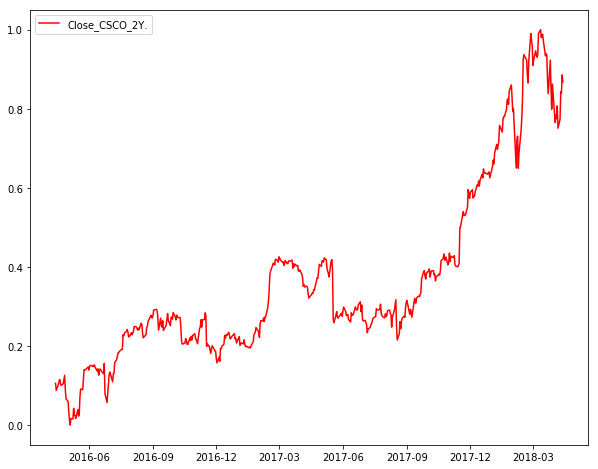

In [5]:
stock_prices = get_stock_price(file_csv_name, normalize=True)

plt.plot(stock_prices.Close, color='red', label='Close_'+file_csv_name[:-3])
plt.legend(loc='best')
plt.show()

#### Set last day Close as y

In [6]:
def load_data(stock_prices, window_size):
    
    amount_of_features = len(stock_prices.columns)
    data = stock_prices.as_matrix()
    sequence_length = window_size + 1
    result = []

    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
            result.append(data[index: index + sequence_length]) # index : index + 22 days as window_size 

    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day y
    y_train = train[:, -1][:,-1] # day y + 1 close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [7]:
X_train, y_train, X_test, y_test = load_data(stock_prices, window_size)

In [8]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(433, 22, 4)

In [9]:
y_train.shape

(433,)

#### Buidling LSTM NN

In [10]:
def build_model(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

###### Model Execution

In [11]:
model = build_model(shape, neurons, d)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=epochs,
    validation_split=0.1,
    verbose=2)

Train on 389 samples, validate on 44 samples
Epoch 1/70
1s - loss: 0.0749 - acc: 0.0000e+00 - val_loss: 0.2071 - val_acc: 0.0000e+00
Epoch 2/70
1s - loss: 0.0168 - acc: 0.0000e+00 - val_loss: 0.1136 - val_acc: 0.0000e+00
Epoch 3/70
1s - loss: 0.0102 - acc: 0.0000e+00 - val_loss: 0.1570 - val_acc: 0.0000e+00
Epoch 4/70
2s - loss: 0.0078 - acc: 0.0000e+00 - val_loss: 0.0972 - val_acc: 0.0000e+00
Epoch 5/70
2s - loss: 0.0069 - acc: 0.0000e+00 - val_loss: 0.1255 - val_acc: 0.0000e+00
Epoch 6/70
2s - loss: 0.0059 - acc: 0.0000e+00 - val_loss: 0.0920 - val_acc: 0.0000e+00
Epoch 7/70
3s - loss: 0.0055 - acc: 0.0000e+00 - val_loss: 0.0818 - val_acc: 0.0000e+00
Epoch 8/70
3s - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0545 - val_acc: 0.0000e+00
Epoch 9/70
3s - loss: 0.0045 - acc: 0.0000e+00 - val_loss: 0.0563 - val_acc: 0.0000e+00
Epoch 10/70
4s - loss: 0.0046 - acc: 0.0000e+00 - val_loss: 0.0367 - val_acc: 0.0000e+00
Epoch 11/70
4s - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0335 - val_a

#### Result on training set and testing set

In [15]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [16]:
trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00107 MSE (0.03 RMSE)
Test Score: 0.00723 MSE (0.09 RMSE)


#### Prediction vs Actual values

In [17]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [32]:
p_test = percentage_difference(model, X_test, y_test)
p_train = percentage_difference(model, X_train, y_train)

#### Plot out prediction

In [22]:
def denormalize(file_csv_name, normalized_value):
    df_to_plot = pd.read_csv(file_csv_name)
    df_to_plot = df_to_plot.replace('null', 0)
    df_to_plot = df_to_plot['Close'].values.reshape(-1,1)
    
    normalized_value = normalized_value.reshape(-1,1)

    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df_to_plot)
    new = min_max_scaler.inverse_transform(normalized_value)
    
    return new

In [23]:
def plot_result(file_csv_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(file_csv_name, normalized_value_p)
    newy_test = denormalize(file_csv_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(file_csv_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()

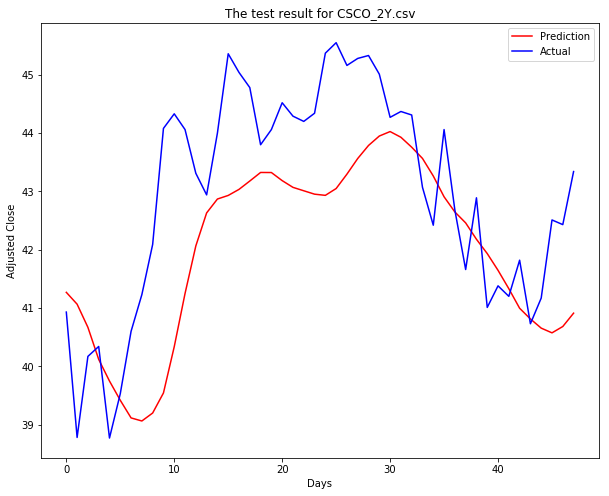

In [25]:
plot_result(file_csv_name, p_test, y_test)

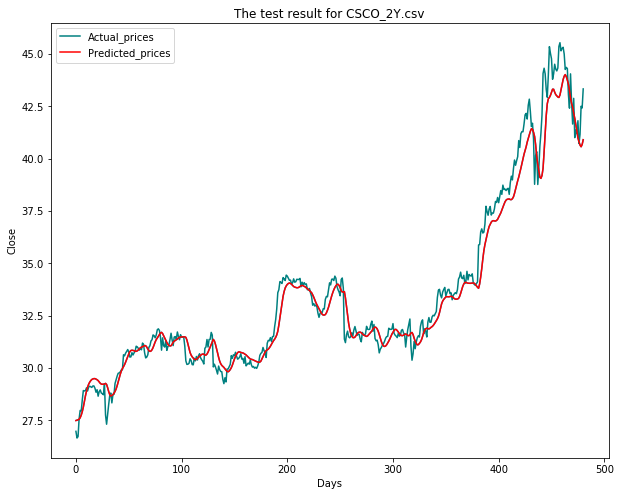

In [61]:
test_diff = denormalize(file_csv_name, p_test)
train_diff = denormalize(file_csv_name, p_train)
diff = np.append(train_diff, test_diff)
plt.plot(diff)

actual_test = denormalize(file_csv_name, y_test)
actual_train = denormalize(file_csv_name, y_train)
actual = np.append(actual_train, actual_test)

plt.plot(actual, label = 'Actual_prices', color = 'teal')
plt.plot(diff, label = 'Predicted_prices', color = 'red')
plt2.legend(loc='best')
plt2.title('The test result for {}'.format(file_csv_name))
plt2.xlabel('Days')
plt2.ylabel('Close')
plt2.show()

In [214]:
model.save('LSTM_Stock_prediction-20170429.h5')

### Tune model

In [219]:
window_size = 22
shape = [4, window_size, 1]
neurons = [128, 128, 32, 1]
epochs = 70

In [220]:
def quick_measure(file_csv_name, window_size, d, shape, neurons, batch_size, epochs):
    df = get_stock_price(file_csv_name)
    X_train, y_train, X_test, y_test = load_data(df, window_size)
    
    model = build_model(shape, neurons, d)
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

Optimial Dropout value

In [222]:
batch_size = 64
dlist = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
neurons_LSTM = [32, 64, 128, 256, 512, 1024, 2048]
dropout_result = {}

for d in dlist:    
    trainScore, testScore = quick_measure(file_csv_name, window_size, d, shape, neurons, batch_size, epochs)
    dropout_result[d] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_11 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

Find the best dropout parameter

In [73]:
min_val = min(dropout_result.values())
min_val_key = [k for k, v in dropout_result.items() if v == min_val]
print(dropout_result)
print(min_val_key)

{0.2: 0.28307063250165238, 0.3: 0.32187784267099279, 0.4: 0.30487769606866333, 0.5: 0.31210789006007345, 0.6: 0.29026408571945994, 0.7: 0.21538778590528587, 0.8: 0.35243767343069377}
[0.7]


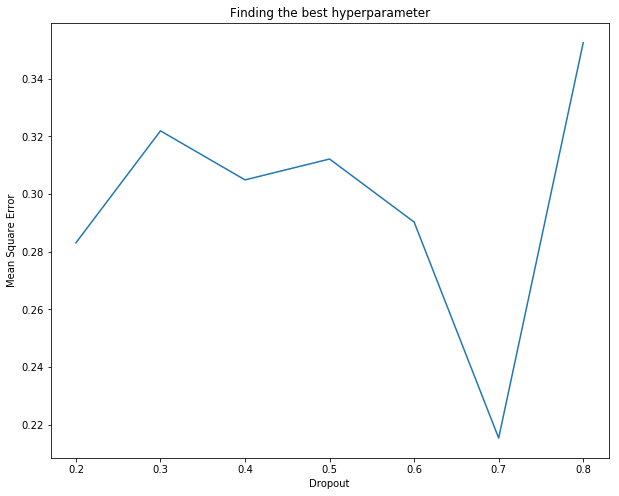

In [74]:
lists = sorted(dropout_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

Optimial epochs value

In [75]:
batch_size = 512
epochslist = [10,20,30,40,50,60,70,80,90,100]
d = 0.7

In [76]:
epochs_result = {}

for epochs in epochslist:    
    trainScore, testScore = quick_measure(file_csv_name, window_size, d, shape, neurons, epochs)
    epochs_result[epochs] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_111 (LSTM)              (None, 120, 32)           4736      
_________________________________________________________________
dropout_111 (Dropout)        (None, 120, 32)           0         
_________________________________________________________________
lstm_112 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dropout_112 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_111 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 17        
Total params: 13,601
Trainable params: 13,601
Non-trainable params: 0
_________________________________________________________________
Train 

310/310 [==============================] - 8s - loss: 0.0204 - acc: 0.0000e+00 - val_loss: 0.1357 - val_acc: 0.0000e+00
Epoch 28/40
310/310 [==============================] - 7s - loss: 0.0221 - acc: 0.0000e+00 - val_loss: 0.1278 - val_acc: 0.0000e+00
Epoch 29/40
310/310 [==============================] - 8s - loss: 0.0257 - acc: 0.0000e+00 - val_loss: 0.1244 - val_acc: 0.0000e+00
Epoch 30/40
310/310 [==============================] - 8s - loss: 0.0247 - acc: 0.0000e+00 - val_loss: 0.1245 - val_acc: 0.0000e+00
Epoch 31/40
310/310 [==============================] - 7s - loss: 0.0259 - acc: 0.0000e+00 - val_loss: 0.1276 - val_acc: 0.0000e+00
Epoch 32/40
310/310 [==============================] - 7s - loss: 0.0238 - acc: 0.0000e+00 - val_loss: 0.1331 - val_acc: 0.0000e+00
Epoch 33/40
310/310 [==============================] - 7s - loss: 0.0220 - acc: 0.0000e+00 - val_loss: 0.1403 - val_acc: 0.0000e+00
Epoch 34/40
310/310 [==============================] - 7s - loss: 0.0254 - acc: 0.0000e+

310/310 [==============================] - 8s - loss: 0.0224 - acc: 0.0000e+00 - val_loss: 0.1744 - val_acc: 0.0000e+00
Epoch 42/60
310/310 [==============================] - 7s - loss: 0.0204 - acc: 0.0000e+00 - val_loss: 0.1821 - val_acc: 0.0000e+00
Epoch 43/60
310/310 [==============================] - 7s - loss: 0.0162 - acc: 0.0000e+00 - val_loss: 0.1894 - val_acc: 0.0000e+00
Epoch 44/60
310/310 [==============================] - 8s - loss: 0.0170 - acc: 0.0000e+00 - val_loss: 0.1959 - val_acc: 0.0000e+00
Epoch 45/60
310/310 [==============================] - 8s - loss: 0.0179 - acc: 0.0000e+00 - val_loss: 0.2019 - val_acc: 0.0000e+00
Epoch 46/60
310/310 [==============================] - 7s - loss: 0.0180 - acc: 0.0000e+00 - val_loss: 0.2068 - val_acc: 0.0000e+00
Epoch 47/60
310/310 [==============================] - 8s - loss: 0.0201 - acc: 0.0000e+00 - val_loss: 0.2112 - val_acc: 0.0000e+00
Epoch 48/60
310/310 [==============================] - 7s - loss: 0.0170 - acc: 0.0000e+

310/310 [==============================] - 8s - loss: 0.0699 - acc: 0.0000e+00 - val_loss: 0.3860 - val_acc: 0.0000e+00
Epoch 16/80
310/310 [==============================] - 8s - loss: 0.0617 - acc: 0.0000e+00 - val_loss: 0.3633 - val_acc: 0.0000e+00
Epoch 17/80
310/310 [==============================] - 8s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.3397 - val_acc: 0.0000e+00
Epoch 18/80
310/310 [==============================] - 8s - loss: 0.0464 - acc: 0.0000e+00 - val_loss: 0.3154 - val_acc: 0.0000e+00
Epoch 19/80
310/310 [==============================] - 8s - loss: 0.0401 - acc: 0.0000e+00 - val_loss: 0.2908 - val_acc: 0.0000e+00
Epoch 20/80
310/310 [==============================] - 8s - loss: 0.0324 - acc: 0.0000e+00 - val_loss: 0.2661 - val_acc: 0.0000e+00
Epoch 21/80
310/310 [==============================] - 8s - loss: 0.0291 - acc: 0.0000e+00 - val_loss: 0.2417 - val_acc: 0.0000e+00
Epoch 22/80
310/310 [==============================] - 8s - loss: 0.0233 - acc: 0.0000e+

310/310 [==============================] - 8s - loss: 0.0180 - acc: 0.0000e+00 - val_loss: 0.2191 - val_acc: 0.0000e+00
Epoch 50/90
310/310 [==============================] - 8s - loss: 0.0178 - acc: 0.0000e+00 - val_loss: 0.2194 - val_acc: 0.0000e+00
Epoch 51/90
310/310 [==============================] - 8s - loss: 0.0164 - acc: 0.0000e+00 - val_loss: 0.2187 - val_acc: 0.0000e+00
Epoch 52/90
310/310 [==============================] - 8s - loss: 0.0201 - acc: 0.0000e+00 - val_loss: 0.2171 - val_acc: 0.0000e+00
Epoch 53/90
310/310 [==============================] - 8s - loss: 0.0195 - acc: 0.0000e+00 - val_loss: 0.2150 - val_acc: 0.0000e+00
Epoch 54/90
310/310 [==============================] - 8s - loss: 0.0188 - acc: 0.0000e+00 - val_loss: 0.2123 - val_acc: 0.0000e+00
Epoch 55/90
310/310 [==============================] - 8s - loss: 0.0192 - acc: 0.0000e+00 - val_loss: 0.2092 - val_acc: 0.0000e+00
Epoch 56/90
310/310 [==============================] - 8s - loss: 0.0182 - acc: 0.0000e+

310/310 [==============================] - 8s - loss: 0.0184 - acc: 0.0000e+00 - val_loss: 0.1830 - val_acc: 0.0000e+00
Epoch 73/100
310/310 [==============================] - 8s - loss: 0.0153 - acc: 0.0000e+00 - val_loss: 0.1843 - val_acc: 0.0000e+00
Epoch 74/100
310/310 [==============================] - 8s - loss: 0.0169 - acc: 0.0000e+00 - val_loss: 0.1857 - val_acc: 0.0000e+00
Epoch 75/100
310/310 [==============================] - 9s - loss: 0.0164 - acc: 0.0000e+00 - val_loss: 0.1873 - val_acc: 0.0000e+00
Epoch 76/100
310/310 [==============================] - 8s - loss: 0.0191 - acc: 0.0000e+00 - val_loss: 0.1889 - val_acc: 0.0000e+00
Epoch 77/100
310/310 [==============================] - 8s - loss: 0.0189 - acc: 0.0000e+00 - val_loss: 0.1904 - val_acc: 0.0000e+00
Epoch 78/100
310/310 [==============================] - 8s - loss: 0.0151 - acc: 0.0000e+00 - val_loss: 0.1920 - val_acc: 0.0000e+00
Epoch 79/100
310/310 [==============================] - 8s - loss: 0.0159 - acc: 0

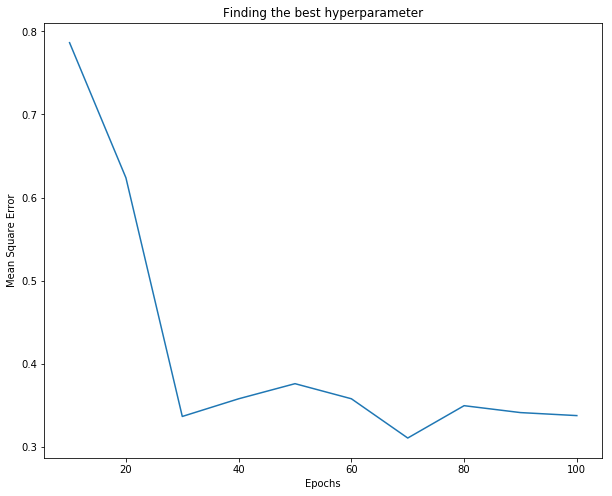

In [77]:
lists = sorted(epochs_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

In [78]:
min_val_epochs = min(epochs_result.values())
min_val_epochs_key = [k for k, v in epochs_result.items() if v == min_val_epochs]
print ('MSE:', min_val_epochs)
print ('Number epochs:', min_val_epochs_key)

MSE: 0.310454328593
Number epochs: [70]


Optimal number of neurons

In [79]:
batch_size = 512
epochs = 70
dropout = 0.7
neuronlist1 = [32, 64, 128, 256, 512]
neuronlist2 = [16, 32, 64]
neurons_result = {}

for neuron_lstm in neuronlist1:
    neurons = [neuron_lstm, neuron_lstm]
    for activation in neuronlist2:
        neurons.append(activation)
        neurons.append(1)
        trainScore, testScore = quick_measure(file_csv_name, window_size, d, shape, neurons, epochs)
        neurons_result[str(neurons)] = testScore
        neurons = neurons[:2]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 120, 32)           4736      
_________________________________________________________________
dropout_131 (Dropout)        (None, 120, 32)           0         
_________________________________________________________________
lstm_132 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dropout_132 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 17        
Total params: 13,601
Trainable params: 13,601
Non-trainable params: 0
_________________________________________________________________
Train 

310/310 [==============================] - 8s - loss: 0.0189 - acc: 0.0000e+00 - val_loss: 0.1943 - val_acc: 0.0000e+00
Epoch 37/70
310/310 [==============================] - 8s - loss: 0.0184 - acc: 0.0000e+00 - val_loss: 0.2023 - val_acc: 0.0000e+00
Epoch 38/70
310/310 [==============================] - 8s - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.2088 - val_acc: 0.0000e+00
Epoch 39/70
310/310 [==============================] - 8s - loss: 0.0184 - acc: 0.0000e+00 - val_loss: 0.2137 - val_acc: 0.0000e+00
Epoch 40/70
310/310 [==============================] - 7s - loss: 0.0197 - acc: 0.0000e+00 - val_loss: 0.2169 - val_acc: 0.0000e+00
Epoch 41/70
310/310 [==============================] - 8s - loss: 0.0175 - acc: 0.0000e+00 - val_loss: 0.2187 - val_acc: 0.0000e+00
Epoch 42/70
310/310 [==============================] - 8s - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.2192 - val_acc: 0.0000e+00
Epoch 43/70
310/310 [==============================] - 8s - loss: 0.0179 - acc: 0.0000e+

310/310 [==============================] - 58s - loss: 0.1200 - acc: 0.0000e+00 - val_loss: 0.5576 - val_acc: 0.0000e+00
Epoch 2/70
310/310 [==============================] - 21s - loss: 0.1185 - acc: 0.0000e+00 - val_loss: 0.5538 - val_acc: 0.0000e+00
Epoch 3/70
310/310 [==============================] - 20s - loss: 0.1173 - acc: 0.0000e+00 - val_loss: 0.5495 - val_acc: 0.0000e+00
Epoch 4/70
310/310 [==============================] - 20s - loss: 0.1159 - acc: 0.0000e+00 - val_loss: 0.5445 - val_acc: 0.0000e+00
Epoch 5/70
310/310 [==============================] - 19s - loss: 0.1144 - acc: 0.0000e+00 - val_loss: 0.5388 - val_acc: 0.0000e+00
Epoch 6/70
310/310 [==============================] - 19s - loss: 0.1124 - acc: 0.0000e+00 - val_loss: 0.5317 - val_acc: 0.0000e+00
Epoch 7/70
310/310 [==============================] - 19s - loss: 0.1105 - acc: 0.0000e+00 - val_loss: 0.5231 - val_acc: 0.0000e+00
Epoch 8/70
310/310 [==============================] - 19s - loss: 0.1079 - acc: 0.0000e

310/310 [==============================] - 20s - loss: 0.0151 - acc: 0.0000e+00 - val_loss: 0.1675 - val_acc: 0.0000e+00
Epoch 45/70
310/310 [==============================] - 21s - loss: 0.0151 - acc: 0.0000e+00 - val_loss: 0.1713 - val_acc: 0.0000e+00
Epoch 46/70
310/310 [==============================] - 20s - loss: 0.0139 - acc: 0.0000e+00 - val_loss: 0.1751 - val_acc: 0.0000e+00
Epoch 47/70
310/310 [==============================] - 22s - loss: 0.0148 - acc: 0.0000e+00 - val_loss: 0.1787 - val_acc: 0.0000e+00
Epoch 48/70
310/310 [==============================] - 20s - loss: 0.0144 - acc: 0.0000e+00 - val_loss: 0.1819 - val_acc: 0.0000e+00
Epoch 49/70
310/310 [==============================] - 21s - loss: 0.0144 - acc: 0.0000e+00 - val_loss: 0.1847 - val_acc: 0.0000e+00
Epoch 50/70
310/310 [==============================] - 20s - loss: 0.0149 - acc: 0.0000e+00 - val_loss: 0.1870 - val_acc: 0.0000e+00
Epoch 51/70
310/310 [==============================] - 21s - loss: 0.0148 - acc: 

310/310 [==============================] - 28s - loss: 0.0638 - acc: 0.0000e+00 - val_loss: 0.3359 - val_acc: 0.0000e+00
Epoch 9/70
310/310 [==============================] - 28s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.2939 - val_acc: 0.0000e+00
Epoch 10/70
310/310 [==============================] - 28s - loss: 0.0301 - acc: 0.0000e+00 - val_loss: 0.2538 - val_acc: 0.0000e+00
Epoch 11/70
310/310 [==============================] - 29s - loss: 0.0220 - acc: 0.0000e+00 - val_loss: 0.2138 - val_acc: 0.0000e+00
Epoch 12/70
310/310 [==============================] - 30s - loss: 0.0158 - acc: 0.0000e+00 - val_loss: 0.1754 - val_acc: 0.0000e+00
Epoch 13/70
310/310 [==============================] - 27s - loss: 0.0148 - acc: 0.0000e+00 - val_loss: 0.1437 - val_acc: 0.0000e+00
Epoch 14/70
310/310 [==============================] - 28s - loss: 0.0156 - acc: 0.0000e+00 - val_loss: 0.1254 - val_acc: 0.0000e+00
Epoch 15/70
310/310 [==============================] - 27s - loss: 0.0189 - acc: 0

310/310 [==============================] - 34s - loss: 0.0129 - acc: 0.0000e+00 - val_loss: 0.1595 - val_acc: 0.0000e+00
Epoch 52/70
310/310 [==============================] - 31s - loss: 0.0130 - acc: 0.0000e+00 - val_loss: 0.1577 - val_acc: 0.0000e+00
Epoch 53/70
310/310 [==============================] - 31s - loss: 0.0128 - acc: 0.0000e+00 - val_loss: 0.1571 - val_acc: 0.0000e+00
Epoch 54/70
310/310 [==============================] - 31s - loss: 0.0127 - acc: 0.0000e+00 - val_loss: 0.1576 - val_acc: 0.0000e+00
Epoch 55/70
310/310 [==============================] - 33s - loss: 0.0131 - acc: 0.0000e+00 - val_loss: 0.1589 - val_acc: 0.0000e+00
Epoch 56/70
310/310 [==============================] - 32s - loss: 0.0123 - acc: 0.0000e+00 - val_loss: 0.1600 - val_acc: 0.0000e+00
Epoch 57/70
310/310 [==============================] - 32s - loss: 0.0127 - acc: 0.0000e+00 - val_loss: 0.1604 - val_acc: 0.0000e+00
Epoch 58/70
310/310 [==============================] - 32s - loss: 0.0129 - acc: 

310/310 [==============================] - 46s - loss: 0.0164 - acc: 0.0000e+00 - val_loss: 0.2251 - val_acc: 0.0000e+00
Epoch 16/70
310/310 [==============================] - 45s - loss: 0.0159 - acc: 0.0000e+00 - val_loss: 0.2118 - val_acc: 0.0000e+00
Epoch 17/70
310/310 [==============================] - 43s - loss: 0.0146 - acc: 0.0000e+00 - val_loss: 0.1964 - val_acc: 0.0000e+00
Epoch 18/70
310/310 [==============================] - 44s - loss: 0.0131 - acc: 0.0000e+00 - val_loss: 0.1805 - val_acc: 0.0000e+00
Epoch 19/70
310/310 [==============================] - 44s - loss: 0.0132 - acc: 0.0000e+00 - val_loss: 0.1671 - val_acc: 0.0000e+00
Epoch 20/70
310/310 [==============================] - 43s - loss: 0.0141 - acc: 0.0000e+00 - val_loss: 0.1586 - val_acc: 0.0000e+00
Epoch 21/70
310/310 [==============================] - 44s - loss: 0.0139 - acc: 0.0000e+00 - val_loss: 0.1550 - val_acc: 0.0000e+00
Epoch 22/70
310/310 [==============================] - 44s - loss: 0.0151 - acc: 

Train on 310 samples, validate on 35 samples
Epoch 1/70
310/310 [==============================] - 110s - loss: 0.1205 - acc: 0.0000e+00 - val_loss: 0.5413 - val_acc: 0.0000e+00
Epoch 2/70
310/310 [==============================] - 47s - loss: 0.1147 - acc: 0.0000e+00 - val_loss: 0.5060 - val_acc: 0.0000e+00
Epoch 3/70
310/310 [==============================] - 46s - loss: 0.1064 - acc: 0.0000e+00 - val_loss: 0.4317 - val_acc: 0.0000e+00
Epoch 4/70
310/310 [==============================] - 47s - loss: 0.0880 - acc: 0.0000e+00 - val_loss: 0.2964 - val_acc: 0.0000e+00
Epoch 5/70
310/310 [==============================] - 47s - loss: 0.0498 - acc: 0.0000e+00 - val_loss: 0.1663 - val_acc: 0.0000e+00
Epoch 6/70
310/310 [==============================] - 48s - loss: 0.0110 - acc: 0.0000e+00 - val_loss: 0.0875 - val_acc: 0.0000e+00
Epoch 7/70
310/310 [==============================] - 48s - loss: 0.0284 - acc: 0.0000e+00 - val_loss: 0.0972 - val_acc: 0.0000e+00
Epoch 8/70
310/310 [==========

310/310 [==============================] - 48s - loss: 0.0044 - acc: 0.0000e+00 - val_loss: 0.0406 - val_acc: 0.0000e+00
Epoch 45/70
310/310 [==============================] - 48s - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0369 - val_acc: 0.0000e+00
Epoch 46/70
310/310 [==============================] - 50s - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0305 - val_acc: 0.0000e+00
Epoch 47/70
310/310 [==============================] - 49s - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.0238 - val_acc: 0.0000e+00
Epoch 48/70
310/310 [==============================] - 47s - loss: 0.0039 - acc: 0.0000e+00 - val_loss: 0.0183 - val_acc: 0.0000e+00
Epoch 49/70
310/310 [==============================] - 48s - loss: 0.0039 - acc: 0.0000e+00 - val_loss: 0.0138 - val_acc: 0.0000e+00
Epoch 50/70
310/310 [==============================] - 49s - loss: 0.0034 - acc: 0.0000e+00 - val_loss: 0.0117 - val_acc: 0.0000e+00
Epoch 51/70
310/310 [==============================] - 48s - loss: 0.0033 - acc: 

310/310 [==============================] - 85s - loss: 0.0200 - acc: 0.0000e+00 - val_loss: 0.2189 - val_acc: 0.0000e+00
Epoch 9/70
310/310 [==============================] - 87s - loss: 0.0162 - acc: 0.0000e+00 - val_loss: 0.1961 - val_acc: 0.0000e+00
Epoch 10/70
310/310 [==============================] - 86s - loss: 0.0131 - acc: 0.0000e+00 - val_loss: 0.1744 - val_acc: 0.0000e+00
Epoch 11/70
310/310 [==============================] - 89s - loss: 0.0124 - acc: 0.0000e+00 - val_loss: 0.1579 - val_acc: 0.0000e+00
Epoch 12/70
310/310 [==============================] - 86s - loss: 0.0133 - acc: 0.0000e+00 - val_loss: 0.1501 - val_acc: 0.0000e+00
Epoch 13/70
310/310 [==============================] - 87s - loss: 0.0146 - acc: 0.0000e+00 - val_loss: 0.1512 - val_acc: 0.0000e+00
Epoch 14/70
310/310 [==============================] - 86s - loss: 0.0143 - acc: 0.0000e+00 - val_loss: 0.1577 - val_acc: 0.0000e+00
Epoch 15/70
310/310 [==============================] - 86s - loss: 0.0138 - acc: 0

310/310 [==============================] - 91s - loss: 0.0028 - acc: 0.0000e+00 - val_loss: 0.0122 - val_acc: 0.0000e+00
Epoch 52/70
310/310 [==============================] - 91s - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 0.0150 - val_acc: 0.0000e+00
Epoch 53/70
310/310 [==============================] - 98s - loss: 0.0030 - acc: 0.0000e+00 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 54/70
310/310 [==============================] - 93s - loss: 0.0030 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 55/70
310/310 [==============================] - 90s - loss: 0.0027 - acc: 0.0000e+00 - val_loss: 0.0150 - val_acc: 0.0000e+00
Epoch 56/70
310/310 [==============================] - 88s - loss: 0.0028 - acc: 0.0000e+00 - val_loss: 0.0149 - val_acc: 0.0000e+00
Epoch 57/70
310/310 [==============================] - 90s - loss: 0.0027 - acc: 0.0000e+00 - val_loss: 0.0075 - val_acc: 0.0000e+00
Epoch 58/70
310/310 [==============================] - 91s - loss: 0.0027 - acc: 

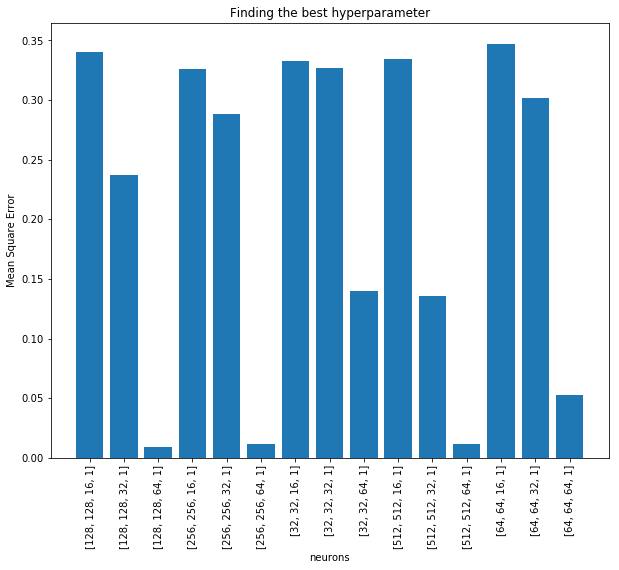

In [80]:
lists = sorted(neurons_result.items())
x,y = zip(*lists)

plt.title('Finding the best hyperparameter')
plt.xlabel('neurons')
plt.ylabel('Mean Square Error')

plt.bar(range(len(lists)), y, align='center')
plt.xticks(range(len(lists)), x)
plt.xticks(rotation=90)

plt.show()

Optimial Dropout value

In [83]:
batch_size = 512
shape = [4, window_size, 1] # feature, window, output
neurons = [128, 128, 64, 1]
epochs = 70
decaylist = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
d = 0.7

In [84]:
def build_model2(layers, neurons, d, decay):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [85]:
def quick_measure(file_csv_name, window_size, d, shape, neurons, epochs, decay):
    df = get_stock_price(file_csv_name)
    X_train, y_train, X_test, y_test = load_data(df, window_size)
    model = build_model2(shape, neurons, d, decay)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

In [86]:
decay_result = {}

for decay in decaylist:    
    trainScore, testScore = quick_measure(file_csv_name, window_size, d, shape, neurons, epochs, decay)
    decay_result[decay] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_161 (LSTM)              (None, 120, 128)          68096     
_________________________________________________________________
dropout_161 (Dropout)        (None, 120, 128)          0         
_________________________________________________________________
lstm_162 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_162 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Trai

310/310 [==============================] - 41s - loss: 0.0089 - acc: 0.0000e+00 - val_loss: 0.1273 - val_acc: 0.0000e+00
Epoch 36/70
310/310 [==============================] - 43s - loss: 0.0095 - acc: 0.0000e+00 - val_loss: 0.1173 - val_acc: 0.0000e+00
Epoch 37/70
310/310 [==============================] - 43s - loss: 0.0094 - acc: 0.0000e+00 - val_loss: 0.1066 - val_acc: 0.0000e+00
Epoch 38/70
310/310 [==============================] - 43s - loss: 0.0089 - acc: 0.0000e+00 - val_loss: 0.0966 - val_acc: 0.0000e+00
Epoch 39/70
310/310 [==============================] - 43s - loss: 0.0095 - acc: 0.0000e+00 - val_loss: 0.0882 - val_acc: 0.0000e+00
Epoch 40/70
310/310 [==============================] - 42s - loss: 0.0092 - acc: 0.0000e+00 - val_loss: 0.0823 - val_acc: 0.0000e+00
Epoch 41/70
310/310 [==============================] - 42s - loss: 0.0090 - acc: 0.0000e+00 - val_loss: 0.0799 - val_acc: 0.0000e+00
Epoch 42/70
310/310 [==============================] - 42s - loss: 0.0086 - acc: 

Train on 310 samples, validate on 35 samples
Epoch 1/70
310/310 [==============================] - 117s - loss: 0.1193 - acc: 0.0000e+00 - val_loss: 0.5414 - val_acc: 0.0000e+00
Epoch 2/70
310/310 [==============================] - 40s - loss: 0.1145 - acc: 0.0000e+00 - val_loss: 0.5197 - val_acc: 0.0000e+00
Epoch 3/70
310/310 [==============================] - 42s - loss: 0.1082 - acc: 0.0000e+00 - val_loss: 0.4843 - val_acc: 0.0000e+00
Epoch 4/70
310/310 [==============================] - 41s - loss: 0.0996 - acc: 0.0000e+00 - val_loss: 0.4301 - val_acc: 0.0000e+00
Epoch 5/70
310/310 [==============================] - 39s - loss: 0.0855 - acc: 0.0000e+00 - val_loss: 0.3490 - val_acc: 0.0000e+00
Epoch 6/70
310/310 [==============================] - 39s - loss: 0.0641 - acc: 0.0000e+00 - val_loss: 0.2456 - val_acc: 0.0000e+00
Epoch 7/70
310/310 [==============================] - 40s - loss: 0.0341 - acc: 0.0000e+00 - val_loss: 0.1391 - val_acc: 0.0000e+00
Epoch 8/70
310/310 [==========

310/310 [==============================] - 60s - loss: 0.0090 - acc: 0.0000e+00 - val_loss: 0.0890 - val_acc: 0.0000e+00
Epoch 45/70
310/310 [==============================] - 52s - loss: 0.0080 - acc: 0.0000e+00 - val_loss: 0.0890 - val_acc: 0.0000e+00
Epoch 46/70
310/310 [==============================] - 55s - loss: 0.0084 - acc: 0.0000e+00 - val_loss: 0.0894 - val_acc: 0.0000e+00
Epoch 47/70
310/310 [==============================] - 63s - loss: 0.0077 - acc: 0.0000e+00 - val_loss: 0.0893 - val_acc: 0.0000e+00
Epoch 48/70
310/310 [==============================] - 57s - loss: 0.0073 - acc: 0.0000e+00 - val_loss: 0.0873 - val_acc: 0.0000e+00
Epoch 49/70
310/310 [==============================] - 55s - loss: 0.0081 - acc: 0.0000e+00 - val_loss: 0.0828 - val_acc: 0.0000e+00
Epoch 50/70
310/310 [==============================] - 60s - loss: 0.0069 - acc: 0.0000e+00 - val_loss: 0.0763 - val_acc: 0.0000e+00
Epoch 51/70
310/310 [==============================] - 62s - loss: 0.0071 - acc: 

310/310 [==============================] - 47s - loss: 0.0181 - acc: 0.0000e+00 - val_loss: 0.0362 - val_acc: 0.0000e+00
Epoch 9/70
310/310 [==============================] - 47s - loss: 0.0335 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 10/70
310/310 [==============================] - 46s - loss: 0.0225 - acc: 0.0000e+00 - val_loss: 0.0916 - val_acc: 0.0000e+00
Epoch 11/70
310/310 [==============================] - 51s - loss: 0.0114 - acc: 0.0000e+00 - val_loss: 0.1325 - val_acc: 0.0000e+00
Epoch 12/70
310/310 [==============================] - 48s - loss: 0.0105 - acc: 0.0000e+00 - val_loss: 0.1650 - val_acc: 0.0000e+00
Epoch 13/70
310/310 [==============================] - 45s - loss: 0.0152 - acc: 0.0000e+00 - val_loss: 0.1834 - val_acc: 0.0000e+00
Epoch 14/70
310/310 [==============================] - 48s - loss: 0.0169 - acc: 0.0000e+00 - val_loss: 0.1884 - val_acc: 0.0000e+00
Epoch 15/70
310/310 [==============================] - 47s - loss: 0.0179 - acc: 0

310/310 [==============================] - 44s - loss: 0.0051 - acc: 0.0000e+00 - val_loss: 0.0272 - val_acc: 0.0000e+00
Epoch 52/70
310/310 [==============================] - 45s - loss: 0.0050 - acc: 0.0000e+00 - val_loss: 0.0266 - val_acc: 0.0000e+00
Epoch 53/70
310/310 [==============================] - 45s - loss: 0.0047 - acc: 0.0000e+00 - val_loss: 0.0235 - val_acc: 0.0000e+00
Epoch 54/70
310/310 [==============================] - 46s - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0182 - val_acc: 0.0000e+00
Epoch 55/70
310/310 [==============================] - 48s - loss: 0.0044 - acc: 0.0000e+00 - val_loss: 0.0128 - val_acc: 0.0000e+00
Epoch 56/70
310/310 [==============================] - 44s - loss: 0.0048 - acc: 0.0000e+00 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 57/70
310/310 [==============================] - 43s - loss: 0.0042 - acc: 0.0000e+00 - val_loss: 0.0062 - val_acc: 0.0000e+00
Epoch 58/70
310/310 [==============================] - 47s - loss: 0.0057 - acc: 

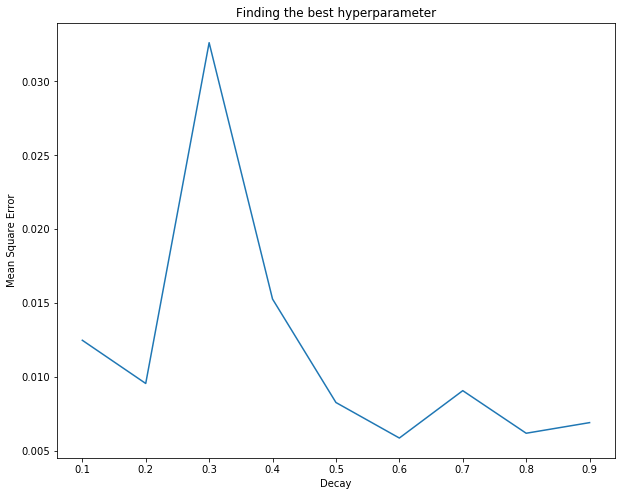

In [87]:
lists = sorted(decay_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Decay')
plt.ylabel('Mean Square Error')
plt.show()

hyperparameter window_size:

In [88]:
neurons = [128, 128, 64, 1]
epochs = 70
d = 0.7 #dropout
decay = 0.6

In [89]:
window_size_list = [5, 10, 22, 60, 120, 180]

window_size_result = {}

for window_size in window_size_list:
    shape = [4, window_size, 1]
    
    trainScore, testScore = quick_measure(file_csv_name, window_size, d, shape, neurons, epochs, decay)
    window_size_result[window_size] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_179 (LSTM)              (None, 5, 128)            68096     
_________________________________________________________________
dropout_179 (Dropout)        (None, 5, 128)            0         
_________________________________________________________________
lstm_180 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_180 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_179 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_180 (Dense)            (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Trai

399/399 [==============================] - 4s - loss: 0.0052 - acc: 0.0025 - val_loss: 0.0798 - val_acc: 0.0000e+00
Epoch 40/70
399/399 [==============================] - 4s - loss: 0.0050 - acc: 0.0025 - val_loss: 0.0741 - val_acc: 0.0000e+00
Epoch 41/70
399/399 [==============================] - 4s - loss: 0.0043 - acc: 0.0025 - val_loss: 0.0673 - val_acc: 0.0000e+00
Epoch 42/70
399/399 [==============================] - 4s - loss: 0.0045 - acc: 0.0025 - val_loss: 0.0600 - val_acc: 0.0000e+00
Epoch 43/70
399/399 [==============================] - 4s - loss: 0.0042 - acc: 0.0025 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 44/70
399/399 [==============================] - 4s - loss: 0.0041 - acc: 0.0025 - val_loss: 0.0478 - val_acc: 0.0000e+00
Epoch 45/70
399/399 [==============================] - 3s - loss: 0.0043 - acc: 0.0025 - val_loss: 0.0441 - val_acc: 0.0000e+00
Epoch 46/70
399/399 [==============================] - 3s - loss: 0.0042 - acc: 0.0025 - val_loss: 0.0420 - val_acc:

359/359 [==============================] - 24s - loss: 0.0825 - acc: 0.0000e+00 - val_loss: 0.3724 - val_acc: 0.0000e+00
Epoch 5/70
359/359 [==============================] - 25s - loss: 0.0701 - acc: 0.0000e+00 - val_loss: 0.2864 - val_acc: 0.0000e+00
Epoch 6/70
359/359 [==============================] - 25s - loss: 0.0493 - acc: 0.0000e+00 - val_loss: 0.1757 - val_acc: 0.0000e+00
Epoch 7/70
359/359 [==============================] - 24s - loss: 0.0224 - acc: 0.0000e+00 - val_loss: 0.0707 - val_acc: 0.0000e+00
Epoch 8/70
359/359 [==============================] - 28s - loss: 0.0081 - acc: 0.0000e+00 - val_loss: 0.0255 - val_acc: 0.0000e+00
Epoch 9/70
359/359 [==============================] - 28s - loss: 0.0365 - acc: 0.0000e+00 - val_loss: 0.0364 - val_acc: 0.0000e+00
Epoch 10/70
359/359 [==============================] - 24s - loss: 0.0243 - acc: 0.0000e+00 - val_loss: 0.0645 - val_acc: 0.0000e+00
Epoch 11/70
359/359 [==============================] - 24s - loss: 0.0113 - acc: 0.000

310/310 [==============================] - 54s - loss: 0.0061 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 48/70
310/310 [==============================] - 50s - loss: 0.0070 - acc: 0.0000e+00 - val_loss: 0.0474 - val_acc: 0.0000e+00
Epoch 49/70
310/310 [==============================] - 49s - loss: 0.0063 - acc: 0.0000e+00 - val_loss: 0.0384 - val_acc: 0.0000e+00
Epoch 50/70
310/310 [==============================] - 49s - loss: 0.0054 - acc: 0.0000e+00 - val_loss: 0.0304 - val_acc: 0.0000e+00
Epoch 51/70
310/310 [==============================] - 50s - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0251 - val_acc: 0.0000e+00
Epoch 52/70
310/310 [==============================] - 50s - loss: 0.0062 - acc: 0.0000e+00 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 53/70
310/310 [==============================] - 52s - loss: 0.0053 - acc: 0.0000e+00 - val_loss: 0.0227 - val_acc: 0.0000e+00
Epoch 54/70
310/310 [==============================] - 51s - loss: 0.0047 - acc: 

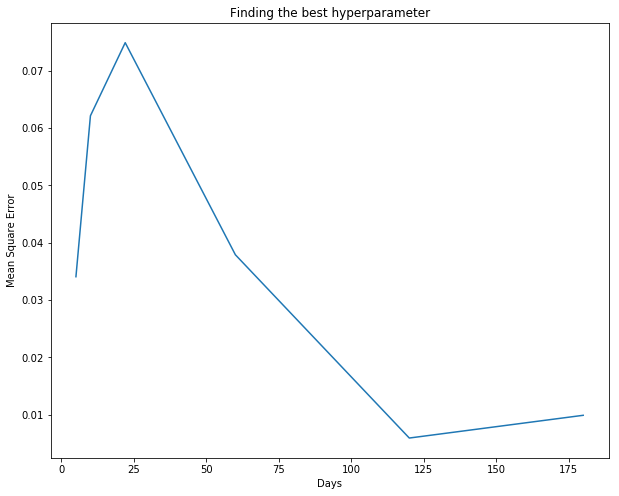

In [90]:
lists = sorted(seq_len_result.items()) # заменить на window_size_result
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Days')
plt.ylabel('Mean Square Error')
plt.show()